# Remove backups

In [ ]:
!rm -rf backup_files

# Install and download basic resources

In [ ]:
!pip install "gymnasium[toy-text]"
!pip install tqdm
!pip install numpy


In [ ]:
#!git clone https://github.com/pablo-sampaio/rl_facil.git

# Import libraries

In [ ]:
import sys
from os import mkdir, path, scandir
from os.path import isdir
import json
from pathlib import Path
from collections import OrderedDict

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pablo's copied functions

## Environments

In [ ]:
def convert_to_flattened_index(indices, dimensions):
    if len(indices) != len(dimensions):
        raise ValueError("Number of indices must match the number of dimensions")

    flattened_index = 0
    for i in range(len(indices)):
        if indices[i] < 0 or indices[i] >= dimensions[i]:
            raise ValueError(f"Value out of bounds at index {i}: {indices[i]}")
        flattened_index = flattened_index * dimensions[i] + indices[i]

    return flattened_index

def convert_from_flattened_index(flattened_index, dimensions):
    indices = [0] * len(dimensions)
    for i in range(len(dimensions)-1, -1, -1):
        indices[i] = flattened_index % dimensions[i]
        flattened_index = flattened_index // dimensions[i]
    return indices


class FromDiscreteTupleToDiscreteObs(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Discrete(self._calculate_discrete_size(env.observation_space))

    def _calculate_discrete_size(self, observation_space):
        size = 1
        assert isinstance(observation_space, gym.spaces.Tuple)
        self.dimensions = []
        for space in observation_space:
            assert isinstance(space, gym.spaces.Discrete)
            size *= space.n
            self.dimensions.append(space.n)
        return size

    def observation(self, observation):
        return convert_to_flattened_index(observation, self.dimensions)


# Converte um espaço contínuo (de ações ou observações) em um espaço discreto.
class BoxSpaceDiscretizer:
    def __init__(self, env_space, bins_per_dimension):
        assert isinstance(env_space, gym.spaces.Box)
        assert len(env_space.shape) == 1, "Only 1-D observations are supported"
        assert env_space.shape[0] == len(bins_per_dimension), "Number of bins must match the dimensions of the space"

        self.bins_per_dim = bins_per_dimension.copy()
        self.full_intervals_per_dim = []
        self.intervals_per_dim = []
        self.total_bins = 1

        for i, bins in enumerate(bins_per_dimension):
            min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
            max_value = env_space.high[i] if not np.isposinf(env_space.high[i]) else np.finfo(np.float64).max/2

            # cria o 'linspace' do valor inicial ao final
            full_linspace = np.linspace(min_value, max_value, bins+1, endpoint=True)
            #print(f">> Dim {i}: full_linspace: {full_linspace}")

            # adiciona o 'linspace' com o valor inicial e o final removidos, por conta do funcionamento do np.digitize():
            #  - valor anterior ao "novo" inicial -> índice "0"
            #  - valor posterior ao "novo" final -> índice "bins-1"
            self.full_intervals_per_dim.append( full_linspace )
            self.intervals_per_dim.append( full_linspace[1:-1] )

            self.total_bins *= bins

    def to_bins(self, original_value):
        bin_vector = [np.digitize(x=original_value[i], bins=intervals)
                      for i, intervals in enumerate(self.intervals_per_dim)]
        return bin_vector

    def to_single_bin(self, original_value):
        bin_vector = [np.digitize(x=original_value[i], bins=intervals)
                      for i, intervals in enumerate(self.intervals_per_dim)]
        return convert_to_flattened_index(bin_vector, self.bins_per_dim)

    def from_bins(self, bin_vector):
        original_value = [ (intervals[bin_vector[dim]] + intervals[bin_vector[dim]+1])/2
                           for dim, intervals in enumerate(self.full_intervals_per_dim) ]
        return original_value

    # it will be useful to convert an entire action into indices of each dimension
    # and then, for the average values of each interval
    def from_single_bin(self, bin_index):
        bin_vector = convert_from_flattened_index(bin_index, self.bins_per_dim)
        return self.from_bins(bin_vector)

    def get_total_bins(self):
        return self.total_bins


class ObservationDiscretizerWrapper(gym.ObservationWrapper):
    '''Classe para converter espaços contínuos em espaços discretos.

    Esta classe converte ambientes de observações (estados) contínuos em ambientes de estados
    discretos. Especificamente, ele converte representações dadas na forma de array de valores float
    em um único inteiro $\geq$ não-negativo (>=0).

    Precisa passar para o construtor uma lista que informa em quantos "bins" vai ser discretizada
    cada dimensão (ou seja, cada valor float) do espaço de estados original.
    '''

    def __init__(self, env : gym.Env, BINS_PER_DIMENSION):
        super().__init__(env)
        # cria um BoxSpaceDiscretizer para converter um array de valores float em um único inteiro >= 0
        # precisa dizer em quantos "bins" vai ser discretizada cada dimensão
        self.discretizer = BoxSpaceDiscretizer(env.observation_space, BINS_PER_DIMENSION)
        self.observation_space = gym.spaces.Discrete(self.discretizer.get_total_bins())

    def observation(self, obs):
        return self.discretizer.to_single_bin(obs)


class ActionDiscretizerWrapper(gym.ActionWrapper):
    '''Classe para converter espaços contínuos em espaços discretos.

    Esta classe converte ambientes de ações contínuas em ambientes de ações discretas.
    Especificamente, ele converte representações dadas na forma de array de valores float
    em um único inteiro $\geq$ não-negativo (>=0).

    Precisa passar para o construtor uma lista que informa em quantos "bins" vai ser discretizada
    cada dimensão (ou seja, cada valor float) do espaço de ações original.
    '''

    def __init__(self, env : gym.Env, BINS_PER_DIMENSION):
        super().__init__(env)
        # cria um BoxSpaceDiscretizer para converter um array de valores float em um único inteiro >= 0
        # precisa dizer em quantos "bins" vai ser discretizada cada dimensão
        self.discretizer = BoxSpaceDiscretizer(env.action_space, BINS_PER_DIMENSION)
        self.action_space = gym.spaces.Discrete(self.discretizer.get_total_bins())

    def action(self, act):
        return self.discretizer.from_single_bin(act)

In [ ]:
def create_wrapped_racetrack_env(observation_as_tuple=False, *args, **kwargs):
    if observation_as_tuple:
        return FromDiscreteTupleToDiscreteObs(RacetrackEnv(*args, **kwargs))
    else:
        return FromDiscreteTupleToDiscreteObs(RacetrackEnv(*args, **kwargs))


def find_positions_with_char(track, character):
    positions = []
    for y, row in enumerate(track):
        for x, ch in enumerate(row):
            if ch == character:
                positions.append((x, y))
    return positions


class RacetrackEnv(gym.Env):
    '''
    A simple environment for a car racing track, based on an environment proposed in the book of Sutton and Barto (2018).

    # Actions
    In each dimension (x and y), the car can accelerate by -1, +1 or 0 (no acceleration).
    The actions represent the different combinations of acceleration in the x and y directions:
    * action 0 - (dx=-1, dy=-1)
    * action 1: (dx=0, dy=-1)
    * action 2: (dx=+1, dy=-1)
    * ...
    * action 8: (dx=+1, dy=+1)

    # Observations
    The observation is the actual state, given by a tuple (x, y, vx, vy), where:
    * x and y are the current position of the car
    * vx and vy are the current velocity in the x and y directions

    # Rewards
    * -1 for each time step
    * 0 when the car reaches the goal
    '''
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, render_mode="rgb_array", collision_restarts=False):
        self.track = [
            "XXXXXXXXXXXXXXXXXX",
            "GG___XXXXXXXXXXXXX",
            "GG______XXXXXXXXXX",
            "GG________XXXXXXXX",
            "GG__________XXXXXX",
            "GG___________XXXXX",
            "GG____________XXXX",
            "XXXX___________XXX",
            "XXXXXXX_________XX",
            "XXXXXXXXX________X",
            "XXXXXXXXXX_______X",
            "XXXXXXXXXX_______X",
            "XXXXXXXXX_______XX",
            "XXXXXXXX________XX",
            "XXXXXXX________XXX",
            "XXXXXX_________XXX",
            "XXXXXX________XXXX",
            "XXXXX________XXXXX",
            "XXXXX_______XXXXXX",
            "XXXXX_______XXXXXX",
            "XXXXX________XXXXX",
            "XXXXXX_______XXXXX",
            "XXXXXX________XXXX",
            "XXXXXXX_______XXXX",
            "XXXXXXXSSSSSSSXXXX",
        ]
        self.collision_restarts = collision_restarts
        self.render_mode = render_mode

        self.action_space = spaces.Discrete(9)  # 9 possible actions (0-8)

        self.vel_limit = 3

        # Dimensions for x position / y position / x velocity / y velocity
        self.obs_dimensions = [len(self.track[0]), len(self.track), 2*self.vel_limit+1, 2*self.vel_limit+1]

        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.obs_dimensions[0]),  # x position
            spaces.Discrete(self.obs_dimensions[1]),  # y position
            spaces.Discrete(self.obs_dimensions[2]),  # x velocity
            spaces.Discrete(self.obs_dimensions[3])   # y velocity
        ))

        self.start_positions = find_positions_with_char(self.track, 'S')

        # para renderização
        self.screen = None
        self.clock = None

        self.colors = {
            'X': (0, 150, 0),     # Color for walls
            '_': (255, 255, 255), # Open tracks
            'G': (0, 0, 0),       # Goals
            'S': (180, 180, 180), # Start positions
            'A': (0, 0, 255),     # Blue for current position
        }
        self.square_size = 20  # Scale factor for rendering
        self.isopen = True

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        idx = self.np_random.choice(len(self.start_positions))
        start_pos = self.start_positions[idx]
        self.current_state = (*start_pos, self.vel_limit, self.vel_limit)  # o valor de self.vel_limit representa a velocidade zero
        if self.render_mode == "human":
            self.render()
        return self.current_state, {}

    def step(self, action):
        x, y, vx, vy = self.current_state
        vx = vx - self.vel_limit
        vy = vy - self.vel_limit

        # Map action to velocity changes
        # i.e. action 0: (dx=-1, dy=-1) / action 1: (dx=0, dy=-1) / action 2: (dx=+1, dy=-1) / ... / action 8: (dx=+1, dy=+1)
        dx = action % 3 - 1
        dy = action // 3 - 1

        # Update velocities with acceleration
        vx_new = vx + dx
        vy_new = vy + dy

        # Limit velocities
        vx_new = np.clip(vx_new, -self.vel_limit, self.vel_limit)
        vy_new = np.clip(vy_new, -self.vel_limit, self.vel_limit)

        # Update position
        x_new = x + vx_new
        y_new = y + vy_new

        # Handle track boundaries and wall colisions
        if x_new < 0 or x_new >= len(self.track[0]) \
                or y_new < 0 or y_new >= len(self.track) \
                or self.track[y_new][x_new] == 'X':
            if self.collision_restarts:
                # go to a random start position
                idx = self.np_random.choice(len(self.start_positions))
                #idx = np.random.choice(len(self.start_positions))
                x_new, y_new = self.start_positions[idx]
                vx_new, vy_new = (0, 0)
            else:
                # stop in current position
                x_new, y_new, vx_new, vy_new = x, y, 0, 0

        # Velocity is internally represented summed to self.vel_limit, just to make it non-negative
        self.current_state = (x_new, y_new, vx_new + self.vel_limit, vy_new + self.vel_limit)

        if self.track[y_new][x_new] == 'G':
            reward = 0   # Reached the goal
            terminated = True
        else:
            reward = -1  # Time step penalty
            terminated = False

        if self.render_mode == "human":
            self.render()

        return self.current_state, reward, terminated, False, {}

    def render_text(self):
        track_copy = self.track.copy()  # Create a copy of the track
        x, y, _, _ = self.current_state
        track_copy[y] = track_copy[y][:x] + 'A' + track_copy[y][x+1:]  # Mark the current position with 'A'
        for row in track_copy:
            print(row)

    def render(self):
        if self.screen is None:
            pygame.init()
            pygame.display.init()
            width = self.square_size * len(self.track[0])
            height = self.square_size * len(self.track)
            self.screen = pygame.display.set_mode((width, height))
            self.font = pygame.font.SysFont(None, 30)
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.screen.fill((255, 255, 255))  # Fill the screen with white

        for y, row in enumerate(self.track):
            for x, ch in enumerate(row):
                color = self.colors[ch]
                pygame.draw.rect(self.screen, color, (x * self.square_size, y * self.square_size, self.square_size, self.square_size))

        x, y, _, _ = self.current_state
        offset = 2
        pygame.draw.rect(self.screen, self.colors['A'], (x*self.square_size + offset, y*self.square_size + offset, self.square_size - 2*offset, self.square_size - 2*offset))

        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        if self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )
        else:
            return self.isopen

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None
            self.isopen = False


"""
if __name__=='__main__':
    import time
    #env = RacetrackEnv(collision_restarts=False, observation_as_tuple=True)
    #env = gym.make("RaceTrack-v0", render_mode="human", collision_restarts=False, observation_as_tuple=True)
    env = create_wrapped_racetrack_env(observation_as_tuple=False)

    state, _ = env.reset()

    terminated = truncated = False
    while not (terminated or truncated):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)

        time.sleep(0.15)
        print("Action:", action)
        print("Next State:", next_state)
        print("Reward:", reward)
        print("Termi/Trunc:", terminated, truncated)
        print()

    env.close()
"""

'\nif __name__==\'__main__\':\n    import time\n    #env = RacetrackEnv(collision_restarts=False, observation_as_tuple=True)\n    #env = gym.make("RaceTrack-v0", render_mode="human", collision_restarts=False, observation_as_tuple=True)\n    env = create_wrapped_racetrack_env(observation_as_tuple=False)\n\n    state, _ = env.reset()\n\n    terminated = truncated = False\n    while not (terminated or truncated):\n        action = env.action_space.sample()\n        next_state, reward, terminated, truncated, _ = env.step(action)\n\n        time.sleep(0.15)\n        print("Action:", action)\n        print("Next State:", next_state)\n        print("Reward:", reward)\n        print("Termi/Trunc:", terminated, truncated)\n        print()\n\n    env.close()\n'

In [ ]:
gym.envs.registration.register(
    id="RaceTrack-v0",
    entry_point=__name__ + ":create_wrapped_racetrack_env",  # Caminho para a classe
    #entry_point="file_path:create_wrapped_racetrack_env",
    max_episode_steps=150,
)

## RL Algorithms

In [ ]:
# Esta função define uma política, em função da tabela Q e do epsilon
# Escolhe a ação gulosa (greedy) com probabilidade 1-epsilon e uma ação aleatória com probabilidade epsilon.
def epsilon_greedy(Q, state, epsilon):
    Q_state = Q[state]
    num_actions = len(Q_state)
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        # em caso de empates, retorna sempre o menor índice -- mais eficiente, porém não é bom para alguns ambientes
        return np.argmax(Q_state)

In [ ]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))
    #Q = np.zeros(shape = (env.observation_space.n, num_actions)) # ruim, porque inicia com vários empates

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            #action = epsilon_greedy_random_tiebreak(Q, state, epsilon)
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)
        # a cada 100 episódios, imprime informação sobre o progresso

    return all_episode_rewards, Q

In [ ]:
# Algoritmo SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))
    #Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # escolhe a próxima ação
        #action = epsilon_greedy_random_tiebreak(Q, state, epsilon)
        action = epsilon_greedy(Q, state, epsilon)

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # escolhe a próxima ação -- usa epsilon-greedy
            #next_action = epsilon_greedy_random_tiebreak(Q, next_state, epsilon)
            next_action = epsilon_greedy(Q, next_state, epsilon)

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor da próxima ação (já escolhida)
                V_next_state = Q[next_state,next_action]

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)

    return all_episode_rewards, Q

In [ ]:
# esta função pode ser usada para converter um array "x" de valores
# numéricos quaisquer em probabilidades
def softmax_probs(Q, state):
    values = Q[state]
    values = values - np.max(values)
    values = np.exp(values)
    values = values / np.sum(values)
    return values

In [ ]:
# escolhe uma ação da Q-table usando uma estratégia softmax
def softmax_choice(Q, state):
    probs = softmax_probs(Q[state])
    return np.random.choice(len(probs), p=probs)

In [ ]:
# define as probabilidades de escolher uma ação usando uma estratégia epsilon-greedy
# um pouco mais detalhada (que considera os empates no valor máximo de Q)
def epsilon_greedy_probs(Q, state, epsilon):
    Q_state = Q[state]
    num_actions = len(Q_state)
    q_max = np.max(Q_state)

    non_greedy_action_probability = epsilon / num_actions
    greedy_actions = np.sum(Q_state == q_max)

    greedy_action_probability = ((1 - epsilon) / greedy_actions) + non_greedy_action_probability

    probs = np.where(Q_state == q_max, greedy_action_probability, non_greedy_action_probability)
    #probs = np.as_numpy([ greedy_action_probability if Q_state[i]==q_max else non_greedy_action_probability
    #                        for i in range(num_actions) ])

    return probs

In [ ]:
def epsilon_greedy_choice(Q, state, epsilon=0.1):
    num_actions = len(Q[state])
    probs = epsilon_greedy_probs(Q, state, epsilon)
    return np.random.choice(num_actions, p=probs)

In [ ]:
# Algoritmo Expected-SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação com a 'behavior policy'
            action = epsilon_greedy_choice(Q, state, epsilon)
            #action = softmax_choice(Q, state)  # bad results!

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                # atualiza conforme a 'target policy'
                p_next_actions = epsilon_greedy_probs(Q, next_state, epsilon)
                #p_next_actions = softmax_probs(Q[next_state_num])
                V_next_state = np.sum( p_next_actions * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        all_episode_rewards.append(sum_rewards)

    return all_episode_rewards, Q

# Plot function

In [ ]:
def plot_results(mode, environments, learning_rates_str, learning_rates, algorithms):

    plt.subplots(2, 2, figsize=(24, 14))
    plt.suptitle(mode)

    subplot = 1

    for environment in environments:

        plt.subplot(2, 2, subplot)
        plt.xticks(learning_rates)
        plt.title(environment)

        for algorithm in algorithms:
            points = [algorithms[algorithm][environment][learning_rate] for learning_rate in learning_rates_str]

            plt.plot(learning_rates, points, label = algorithm)

        subplot += 1

        plt.legend(loc = "best")
        plt.xlabel("Learning rates")
        plt.ylabel("Mean of rewards")

    #plt.subplots_adjust(hspace = 0.25, wspace = 0.20)
    plt.show()

# Experiments

## Basic variables

In [ ]:
environments = OrderedDict([
    ("FrozenLake-v1", gym.make("FrozenLake-v1")),
    ("Taxi-v3", gym.make("Taxi-v3")),
    ("CliffWalking-v0", gym.make("CliffWalking-v0")),
    ("RaceTrack-v0", gym.make("RaceTrack-v0"))
])

environments_names = list(environments.keys())

learning_rates_str = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

runs = {
    "interim": 3, #50000
    "asymptotic": 3 #30
}
n_episodes = {
    "interim": 10, #100
    "asymptotic": 3 #100000
}

step_backup = {
    "interim": 1, #1000
    "asymptotic": 1
}

qlearning = {}
sarsa = {}
expected_sarsa = {}

## Backup functions

In [ ]:
def is_int(s):
    try:
        int(s)
    except ValueError:
        return False
    else:
        return True

backup_folder_name = "backup_files"

def save_backup(type, mode, environment, learning_rate_str, run, save_list):
    name = type + ".backup"
    if not isdir(backup_folder_name):
        mkdir(backup_folder_name)
    if type == "dict":
        with open(backup_folder_name + "/" + name, "w") as backup_file:
            json.dump(save_list, backup_file, indent = 4)
    else:
        with open(backup_folder_name + "/" + name, "w") as backup_file:
            backup_file.write(mode + " " + environment + " " + learning_rate_str + " " + str(run) + " " + " ".join(str(data) for data in save_list))

def load_backup(type = "text"):
    if not isdir(backup_folder_name):
        return []
    name = type + ".backup"
    if Path(backup_folder_name + "/" + name).is_file():
        if type == "dict":
            with open(backup_folder_name + "/" + name, "r") as backup_file:
                backup = json.load(backup_file)
        else:
            with open(backup_folder_name + "/" + name, "r") as backup_file:
                backup = backup_file.read().split()
                backup[3:] = list(map(lambda n: int(n) if is_int(n) else float(n), backup[3:]))
    else:
        return []
    return backup

## Runs

In [ ]:
backup = load_backup()

modes = ["interim", "asymptotic"]

if len(backup) > 0:
    modes = modes[modes.index(backup[0]) :]

dicts_backup = load_backup("dict")

if len(dicts_backup) > 0:
    qlearning = dicts_backup[0]
    sarsa = dicts_backup[1]
    expected_sarsa = dicts_backup[2]
else:
    qlearning = {}
    sarsa = {}
    expected_sarsa = {}

for mode in modes:

    print("Mode: " + mode)

    if mode not in qlearning or mode not in sarsa or mode not in expected_sarsa:
        qlearning[mode] = {}
        sarsa[mode] = {}
        expected_sarsa[mode] = {}

    if len(backup) > 0 and backup[0] == mode:
        filtered_environments = OrderedDict([item for item in list(environments.items())[environments_names.index(backup[1]) :]])
    else:
        filtered_environments = environments

    for environment in filtered_environments:

        print("Environment: " + environment)

        if environment not in qlearning[mode] or environment not in sarsa[mode] or environment not in expected_sarsa[mode]:
            qlearning[mode][environment] = {}
            sarsa[mode][environment] = {}
            expected_sarsa[mode][environment] = {}

        if len(backup) > 0 and backup[0] == mode and backup[1] == environment:
            lr_index = learning_rates_str.index(backup[2])
            filtered_learning_rates_str = learning_rates_str[lr_index :]
            filtered_learning_rates = learning_rates[lr_index :]
        else:
            filtered_learning_rates = learning_rates
            filtered_learning_rates_str = learning_rates_str

        for learning_rate in enumerate(filtered_learning_rates):

            if len(backup) == 0:
                sum_rewards_per_run_qlearning = 0
                sum_rewards_per_run_sarsa = 0
                sum_rewards_per_run_expected_sarsa = 0

                initial_run = 0
            elif backup[0] == mode and backup[1] == environment and backup[2] == filtered_learning_rates_str[learning_rate[0]]:
                sum_rewards_per_run_qlearning = backup[4]
                sum_rewards_per_run_sarsa = backup[5]
                sum_rewards_per_run_expected_sarsa = backup[6]

                initial_run = backup[3] + 1

            for run in (progress_bar := tqdm(range(initial_run, runs[mode]))):

                progress_bar.set_description("Learning rate: " + filtered_learning_rates_str[learning_rate[0]] + " Runs: " + str(runs[mode]))

                rewards_per_episode, _ = run_qlearning(environments[environment], n_episodes[mode], learning_rate[1])
                sum_rewards_per_run_qlearning += sum(rewards_per_episode) / len(rewards_per_episode)

                rewards_per_episode, _ = run_sarsa(environments[environment], n_episodes[mode], learning_rate[1])
                sum_rewards_per_run_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

                rewards_per_episode, _ = run_expected_sarsa(environments[environment], n_episodes[mode], learning_rate[1])
                sum_rewards_per_run_expected_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

                if (run % step_backup[mode] == 0):
                    save_backup("text", mode, environment, filtered_learning_rates_str[learning_rate[0]], run, [sum_rewards_per_run_qlearning, sum_rewards_per_run_sarsa, sum_rewards_per_run_expected_sarsa])

            qlearning[mode][environment][filtered_learning_rates_str[learning_rate[0]]] = sum_rewards_per_run_qlearning / runs[mode]
            sarsa[mode][environment][filtered_learning_rates_str[learning_rate[0]]] = sum_rewards_per_run_sarsa / runs[mode]
            expected_sarsa[mode][environment][filtered_learning_rates_str[learning_rate[0]]] = sum_rewards_per_run_expected_sarsa / runs[mode]

            save_backup("dict", mode, environment, filtered_learning_rates_str[learning_rate[0]], 0, [qlearning, sarsa, expected_sarsa])

Mode: interim
Environment: CliffWalking-v0


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Environment: RaceTrack-v0


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Mode: asymptotic
Environment: FrozenLake-v1


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00, 104.73it/s]


Environment: Taxi-v3


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Environment: CliffWalking-v0


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Environment: RaceTrack-v0


Learning rate: 1.0 Runs: 3: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s]


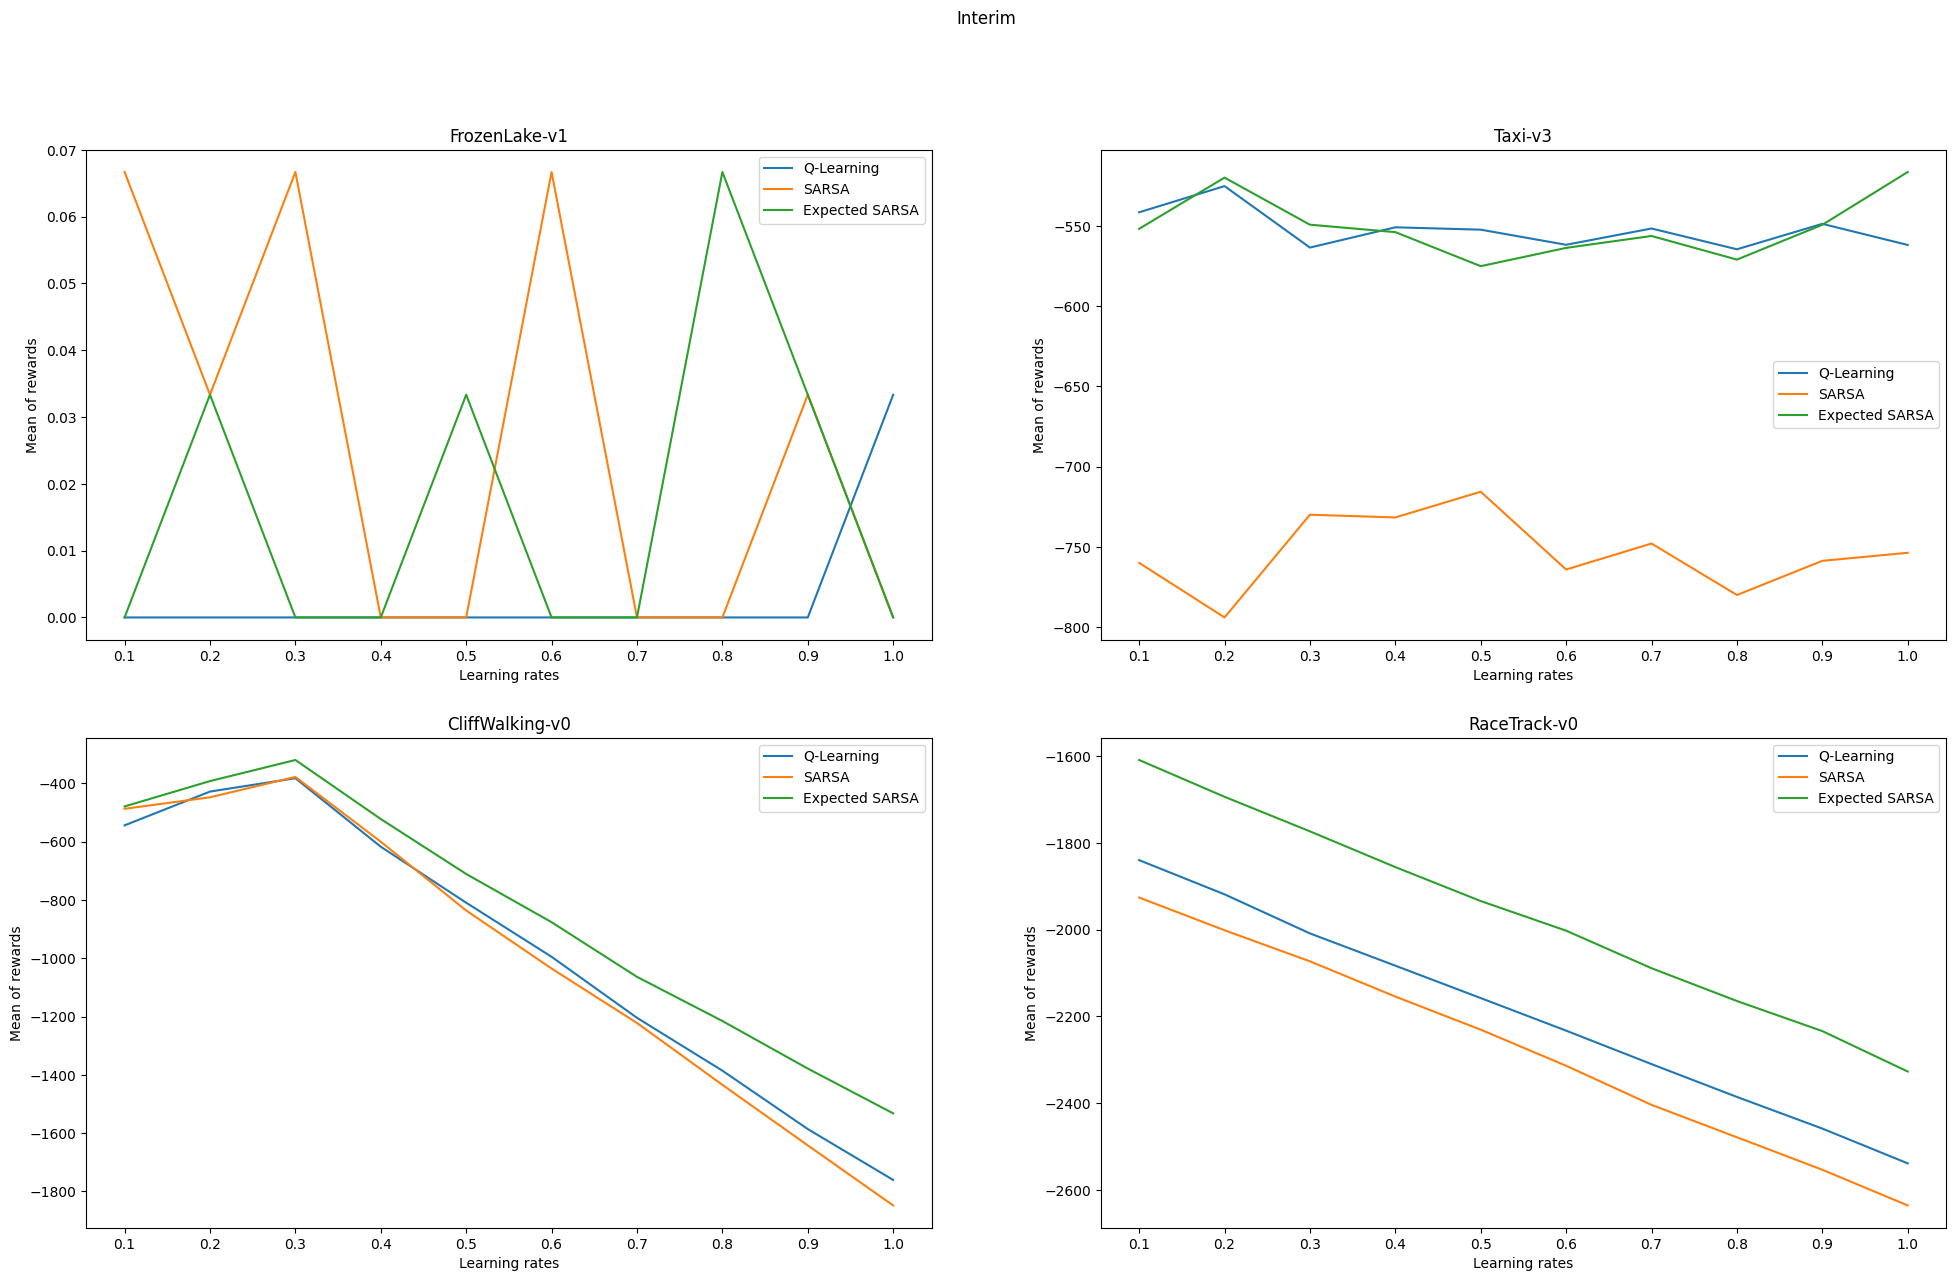

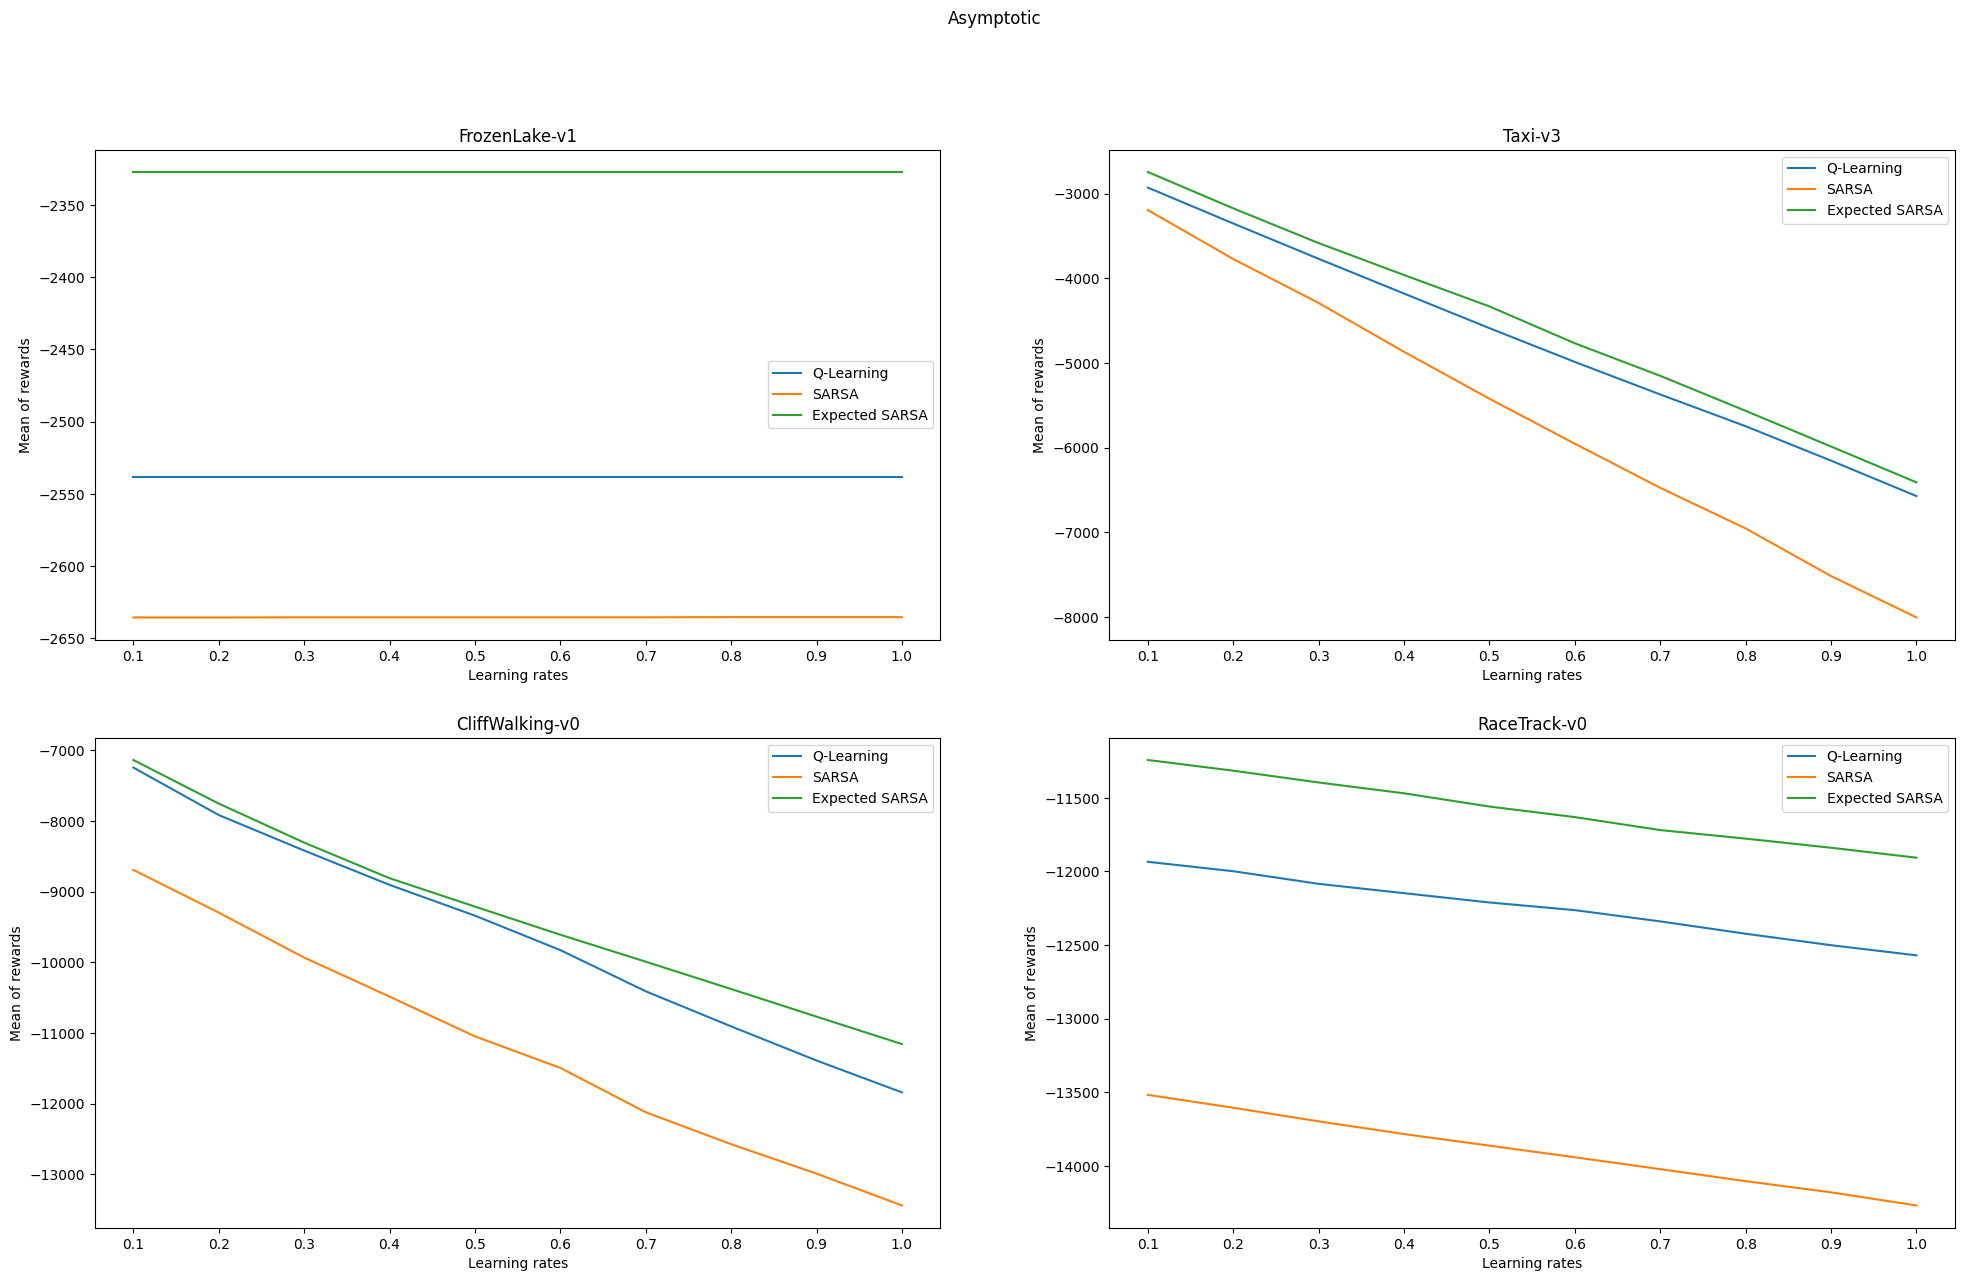

In [ ]:
plot_results("Interim", environments, learning_rates_str, learning_rates, {
    "Q-Learning": qlearning["interim"],
    "SARSA": sarsa["interim"],
    "Expected SARSA": expected_sarsa["interim"]
})

print("\n")

plot_results("Asymptotic", environments, learning_rates_str, learning_rates, {
    "Q-Learning": qlearning["asymptotic"],
    "SARSA": sarsa["asymptotic"],
    "Expected SARSA": expected_sarsa["asymptotic"]
})